In [1]:
import os
os.chdir('../')

In [13]:
# dcgan_reproduction/train.py
import random, pathlib, datetime
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
from models.Generator import Generator
from models.Discriminator import Discriminator

In [19]:
import warnings 
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=RuntimeWarning)

# Traning

## Parameters

In [4]:
SEED = 1337
random.seed(SEED); torch.manual_seed(SEED); np.random.seed(SEED)

data = 'MINST'

IMG_SIZE = 64
BATCH    = 128
EPOCHS   = 25
NZ       = 100
LR       = 2e-4
BETA1    = 0.5
LABEL_FRAC = 0.10

ROOT     = pathlib.Path("./")
DATA_DIR = ROOT/"data"
RES_DIR  = ROOT/f"results/{data}"; RES_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR  = ROOT/f"results/{data}/model"; MODEL_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:", DEVICE)

Device: mps


## Data Loading

In [5]:
transform = T.Compose([T.Resize(IMG_SIZE), T.ToTensor(), T.Normalize((0.5,), (0.5,))])
train_all = dset.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = DataLoader(train_all, BATCH, shuffle=True, num_workers=2)

test_set = dset.MNIST(root=DATA_DIR, train=False, transform=transform)
test_loader = DataLoader(test_set, BATCH, shuffle=False)

## Model Training

In [6]:
netG, netD = Generator(NZ).to(DEVICE), Discriminator().to(DEVICE)
netG.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if hasattr(m,'weight') and m.weight is not None else None)
netD.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if hasattr(m,'weight') and m.weight is not None else None)

criterion = nn.BCELoss()
optD = optim.AdamW(netD.parameters(), lr=LR, betas=(BETA1,0.999), weight_decay=1e-4)
optG = optim.AdamW(netG.parameters(), lr=LR, betas=(BETA1,0.999), weight_decay=1e-4)

fixed_noise = torch.randn(64, NZ, 1, 1, device=DEVICE)

In [7]:
# ─── Training ────────────────────────────────────────────────────────────────
print("===> Training")
for epoch in range(1, EPOCHS+1):
    for i,(real,_ ) in enumerate(train_loader):
        # Train D
        netD.zero_grad()
        real = real.to(DEVICE); b=real.size(0)
        label_real = torch.ones(b, device=DEVICE)
        loss_real = criterion(netD(real).view(-1), label_real)

        noise = torch.randn(b, NZ,1,1, device=DEVICE)
        fake = netG(noise)
        label_fake = torch.zeros(b, device=DEVICE)
        loss_fake = criterion(netD(fake.detach()).view(-1), label_fake)
        loss_D = loss_real + loss_fake
        loss_D.backward(); optD.step()

        # Train G
        netG.zero_grad()
        loss_G = criterion(netD(fake).view(-1), label_real)  # want ones
        loss_G.backward(); optG.step()

        if i%100==0:
            print(f"[E{epoch}/{EPOCHS}] [{i}/{len(train_loader)}] D:{loss_D.item():.3f} G:{loss_G.item():.3f}")
    # save epoch samples
    with torch.no_grad():
        vutils.save_image(netG(fixed_noise).cpu(), RES_DIR/f"fake_epoch_{epoch:03d}.png", normalize=True)

===> Training
[E1/25] [0/469] D:1.397 G:0.699
[E1/25] [100/469] D:0.028 G:4.181
[E1/25] [200/469] D:0.008 G:5.455
[E1/25] [300/469] D:0.612 G:2.084
[E1/25] [400/469] D:1.270 G:1.415
[E2/25] [0/469] D:0.444 G:1.967
[E2/25] [100/469] D:1.051 G:2.741
[E2/25] [200/469] D:0.592 G:1.773
[E2/25] [300/469] D:0.797 G:0.899
[E2/25] [400/469] D:0.854 G:3.113
[E3/25] [0/469] D:0.769 G:1.598
[E3/25] [100/469] D:0.686 G:1.882
[E3/25] [200/469] D:0.685 G:2.626
[E3/25] [300/469] D:0.563 G:1.292
[E3/25] [400/469] D:0.932 G:0.893
[E4/25] [0/469] D:0.846 G:3.720
[E4/25] [100/469] D:0.573 G:3.259
[E4/25] [200/469] D:0.521 G:2.146
[E4/25] [300/469] D:1.256 G:4.539
[E4/25] [400/469] D:1.145 G:1.709
[E5/25] [0/469] D:0.526 G:3.433
[E5/25] [100/469] D:1.629 G:1.300
[E5/25] [200/469] D:0.823 G:2.835
[E5/25] [300/469] D:0.312 G:2.801
[E5/25] [400/469] D:0.393 G:2.552
[E6/25] [0/469] D:0.455 G:4.036
[E6/25] [100/469] D:0.468 G:2.727
[E6/25] [200/469] D:0.480 G:2.818
[E6/25] [300/469] D:0.392 G:3.034
[E6/25] [400

In [8]:
print("===> Saving checkpoints")
torch.save(netG.state_dict(), MODEL_DIR/"netG_final.pth")
torch.save(netD.state_dict(), MODEL_DIR/"netD_final.pth")

===> Saving checkpoints


# Evaluation

## Quantitative evaluation

In [20]:
print("===> Linear‑probe evaluation")

lab_n = int(len(train_all)*LABEL_FRAC)
lab_idx = np.random.choice(len(train_all), lab_n, False)
train_lab_loader = DataLoader(Subset(train_all, lab_idx), BATCH, shuffle=False)
POOL = nn.AdaptiveMaxPool2d((4,4))

@torch.no_grad()
def feats(loader):
    out, ys = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        h = x
        acts = []
        for layer in netD.main:
            h = layer(h)
            if isinstance(layer, nn.Conv2d) and h.shape[2] >= 4 and h.shape[3] >= 4:
                acts.append(POOL(h).cpu())
        pooled = torch.cat([a.view(a.size(0), -1) for a in acts], dim=1)
        out.append(pooled)
        ys.append(y)
    return torch.cat(out).numpy(), torch.cat(ys).numpy()

netD.eval()

X_tr, y_tr = feats(train_lab_loader)
X_te, y_te = feats(test_loader)

# 1) Standardize each feature across the training set
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

clf = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_tr,y_tr)
acc = accuracy_score(y_te, clf.predict(X_te))*100
rep = f"{datetime.datetime.now()}: linear‑probe ({LABEL_FRAC:.2%} labels) = {acc:.2f}%\n"

print(rep); (RES_DIR/"eval.txt").write_text(rep)

===> Linear‑probe evaluation


/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/utkarshgoyal/Desktop/Cornell Tech/3. Spring 2025/specialtopics/CS5996/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWa

2025-04-30 23:45:17.065322: linear‑probe (10.00% labels) = 97.92%



66

**Comments:** With only 10 % of the MNIST labels, a frozen Discriminator + one single linear layer on top gets 98 % test accuracy. Getting 98 % in a purely unsupervised→linear-probe setup means your Discriminator’s intermediate features are nearly as powerful as fully supervised ones.

**Therefore DCGAN has learned very rich, discriminative representations of handwritten digits.**

## Qualitative sanity checks

In [ ]:
print("===> Qualitative sanity checks")

def latent_interpolation(n_steps=10):
    z0,z1 = torch.randn(1,NZ,1,1,device=DEVICE), torch.randn(1,NZ,1,1,device=DEVICE)
    alphas = torch.linspace(0,1,n_steps,device=DEVICE).view(-1,1,1,1)
    z = z0 + alphas*(z1-z0)
    with torch.no_grad(): imgs = netG(z).cpu()
    vutils.save_image(imgs, RES_DIR/"interpolation.png", nrow=n_steps, normalize=True)

latent_interpolation()

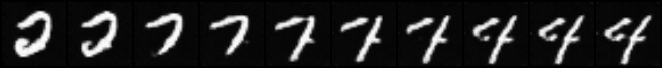

**Comments:** Smooth gradual changes (each step is a morph between the two endpoint digits) indicate a well-structured, continuous latent space.

In [ ]:
# nearest‑neighbour check
print("  computing nearest neighbours… (may take a minute)")
@torch.no_grad()
def nn_check(num_fake=8, real_subset=6000):
    # sample fakes
    fake = netG(torch.randn(num_fake,NZ,1,1,device=DEVICE)).cpu()
    # prep subset of real images for speed
    sub_idx = np.random.choice(len(train_all), real_subset, False)
    real_subset_imgs = torch.stack([train_all[i][0] for i in sub_idx])  # [R,1,64,64]
    f = fake.view(num_fake,-1)
    r = real_subset_imgs.view(real_subset,-1)
    # compute L2 distances in chunks to save RAM
    nn_real = []
    for v in f:
        dists = ((r - v).pow(2)).sum(1)
        idx = torch.argmin(dists).item()
        nn_real.append(real_subset_imgs[idx])
    grid = torch.cat([fake, torch.stack(nn_real)],0)
    vutils.save_image(grid, RES_DIR/"nearest_neighbour.png", nrow=num_fake, normalize=True)

nn_check()

print("Finished. See result images & logs in", RES_DIR)

===> Qualitative sanity checks
  computing nearest neighbours… (may take a minute)
Finished. See result images & logs in results/MINST


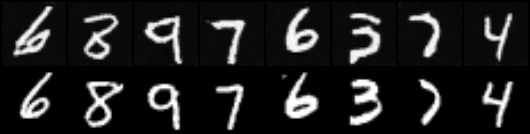

**Comments:** The shapes are extremely close (same strokes, slants, even quirks), which suggests your Generator may be overfitting rather than truly sampling the underlying digit distribution.

# Overall Comments 

- Representation quality: The D’s features are nearly as good as a small supervised network.

- Memorization risk: The fakes and nearest real neighbours look too identical—the Generator may be overfitting.